<a href="https://colab.research.google.com/github/sibyjackgrove/SolarPV-DER-simulation-utility/blob/master/examples/PV-DER_usage_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import classes
Import classes neccessary to define instances of the PV-DER model, events, simulation, and results.

In [1]:
import pvder
from pvder.DER_wrapper import DERModel
from pvder.grid_components import Grid
from pvder.dynamic_simulation import DynamicSimulation
from pvder.simulation_events import SimulationEvents
from pvder.simulation_utilities import SimulationResults
from pvder import utility_functions

#Import Python modules
import logging
import numpy as np
import scipy as sci
import math

import matplotlib as matplotlib
print('Scipy version:',sci.__version__)
print('Numpy version:',np.__version__)
print('Matplotlib version:',matplotlib.__version__)
print('pvder version:',pvder.__version__)

#%matplotlib inline    #To show interactive plot in the notebook cell

Scipy version: 1.7.3
Numpy version: 1.21.5
Matplotlib version: 3.5.1


## Initialize voltage (for use with loop mode)

In [2]:
logging.debug('test')
Va=164.78-124.57j
Vb=-190.96-78.26j
Vc=26.24+206.56j
Vrms = abs(Va)/math.sqrt(2)
print('Vrms:{:.2f}'.format(Vrms))
print('Va:{:.2f},Vb:{:.2f},Vc:{:.2f}'.format(Va,Vb,Vc))
print('V0:{:.2f}'.format(Va+Vb+Vc))

events1 = SimulationEvents(verbosity = 'DEBUG')
grid1 = Grid(events=events1,unbalance_ratio_b=1.0,unbalance_ratio_c=1.0)


Vrms:146.07
Va:164.78-124.57j,Vb:-190.96-78.26j,Vc:26.24+206.56j
V0:0.06+3.73j


In [3]:
grid1.Vagrid

(40.83+0j)

## Select options

In [4]:
stand_alone = True
steady_state = True
loop=False

model_type = 'ThreePhaseUnbalanced' #Model type
#three phase model types: 'ThreePhaseBalanced','ThreePhaseUnbalanced','ThreePhaseUnbalancedConstantVdc'
#single phase model types: 'SinglePhase'

der_verbosity = 'DEBUG' #Logging verbosity
config_file = r'../config_der.json'
parameter1 = '250'#'50_type1'#'50','10' '50_constantVdc','50_balanced','250'

## Select model

In [5]:
if stand_alone:
    PV_DER1 = DERModel(events=events1,configFile=config_file,derId=parameter1,
                       gridModel=grid1,                       
                       standAlone = stand_alone,steadyStateInitialization=steady_state)   #modelType=model_type
else:
    PV_DER1 = DERModel(events=events1,configFile=config_file,derId=parameter1,
                       Vrmsrated = Vrms,
                       gridVoltagePhaseA = Va,gridVoltagePhaseB = Vb,gridVoltagePhaseC = Vc,gridFrequency=2*math.pi*60.0,                       
                       standAlone = stand_alone,steadyStateInitialization=steady_state,
                       verbosity = der_verbosity)        
    
sim1 = DynamicSimulation(gridModel=grid1,derModel=PV_DER1.DER_model,events = events1,verbosity = 'INFO',solverType='odeint',loopMode=loop) #'odeint','ode-vode-bdf'
results1 = SimulationResults(simulation = sim1,per_unit=True,verbosity = 'INFO')
PV_DER1.DER_model.show_PV_DER_parameters('controller_gains')

INFO:pvder_logger:DER configuration with ID:250 was found in ../config_der.json
INFO:pvder_logger:DER configuration with ID:250 was found in ../config_der.json
INFO:pvder_logger:Updated DER argument verbosity from DER_config
ERROR:pvder_logger:-SolarPVDERThreePhase_1:DER configuration with ID:250 needs 24 states, but only 23 states were found for SolarPVDERThreePhase DER model!


----Parameters for DER with ID:250----
Current controller :
Kp_GCC:6000.000
Ki_GCC:2000.000
wp:200000.000
DC link voltage controller :
Kp_DC:-2.000
Ki_DC:-10.000
Reactive power controller :
Kp_Q:0.200
Ki_Q:10.000


## Add simulation events

In [6]:
events1.add_grid_event(0.5,0.97,0.0,60.0) #Add grid event
events1.add_solar_event(0.75,75,298.15) #Add solar event
events1.show_events() #Show events

Showing all event in events instance -events_1
Total solar events:1
Total grid events:1
t:0.500, Grid event, Grid voltage: Magnitude:0.97, Angle:0.000 V, Frequency is 60.00
t:0.750,Solar event, Solar insolation is 75.00 W/cm2, Temperature is 298.15


## Specify run time flags, simulation time, and run simulation 

In [7]:
%%time
PV_DER1.DER_model.MPPT_ENABLE=False
PV_DER1.DER_model.RAMP_ENABLE = False
PV_DER1.DER_model.VOLT_VAR_ENABLE = False
PV_DER1.DER_model.LVRT_ENABLE = False
PV_DER1.DER_model.HVRT_ENABLE = False
PV_DER1.DER_model.LFRT_ENABLE = False
PV_DER1.DER_model.DO_EXTRA_CALCULATIONS = False
PV_DER1.DER_model.use_frequency_estimate=False
sim1.jacFlag = False
sim1.DEBUG_SIMULATION = False
sim1.DEBUG_VOLTAGES = True
sim1.DEBUG_CURRENTS = True
sim1.DEBUG_POWER = False
sim1.DEBUG_CONTROLLERS  = True
sim1.DEBUG_PLL = False
sim1.per_unit = True
sim1.DEBUG_SOLVER  = False
sim1.tStop = 5.0
sim1.tInc = 1/120.# 0.001
PV_DER1.DER_model._del_t_frequency_estimate = sim1.tInc 

if sim1.loop_mode:
    t0 = 0.0
    dt = 0.01
    n_time_steps = 100
    Vat = Va
    Vbt = Vb
    Vct = Vc
    
    for i in range(n_time_steps):
        t_sim= [t0,t0+dt]
        sim1.run_simulation(gridVoltagePhaseA=Vat/Grid.Vbase, gridVoltagePhaseB=Vbt/Grid.Vbase, gridVoltagePhaseC=Vct/Grid.Vbase, y0=sim1.y0, t=t_sim) #[0.0,0.01]
        t0 = t_sim[-1]
else:
    sim1.run_simulation()
    
PV_DER1.DER_model.validate_model()

PV_DER1.DER_model.show_PV_DER_states('voltage')
PV_DER1.DER_model.show_PV_DER_states('current')
PV_DER1.DER_model.show_PV_DER_states('power')
PV_DER1.DER_model.show_PV_DER_states('duty cycle')

None-sim_1:Simulation started at 0.0 s and will end at 5.0 s


None-sim_1:Simulation was completed in 00:00:01
Active power output error:0.0000 p.u.
Reactive power output error:0.0000 p.u.
Inverter filter active power loss error:0.0003 p.u.
Inverter filter reactive power loss error:0.0000 p.u.

______-SolarPVDERThreePhase_1 - Voltage_____
Vdc:750.04
Vta:312.41+67.13j V
Vtb:-98.07-304.12j V,Vtb:-214.34+236.99j V
Vtn:0.00+0.00j V
Va:314.79+22.65j V
Vb:-137.78-283.94j V,Vc:-177.01+261.29j V
Vn:0.00+0.00j V
Vtrms:225.95 V
Vpccrms:223.17 V

______-SolarPVDERThreePhase_1 - Current_____
ia:392.77+28.26j A
ib:-171.91-354.28j A,ic:-220.86+326.02j A
In:0.00-0.00j A
Irms:278.45 V

______-SolarPVDERThreePhase_1 - Power_____
Ppv:186934.6 W
S:186902.7+26308.4j VA
S_PCC:186422.0+1.2j VA

______-SolarPVDERThreePhase_1 - Duty cycle_____
ma:0.83+0.18j
mb:-0.26-0.81j,mc:-0.57+0.63j
m0:0.00+0.00j
CPU times: total: 1.03 s
Wall time: 1.07 s


c:\Users\splathottam\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:250: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


### Plot results

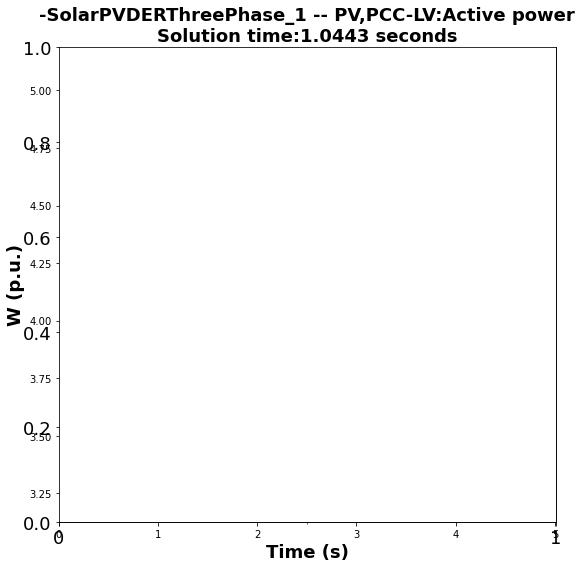

In [8]:
results1.PER_UNIT = False
results1.PLOT_TITLE = True
results1.font_size = 18
results1.plot_DER_simulation(plot_type='active_power_Ppv_Pac_PCC')#_Ppv_Pac_PCC

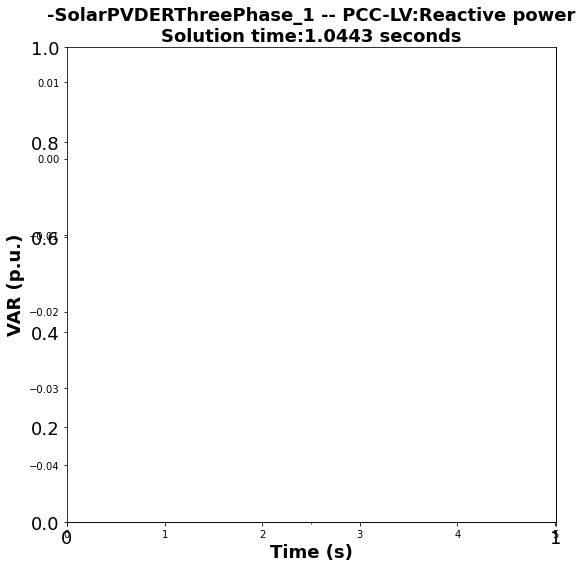

In [9]:
results1.plot_DER_simulation(plot_type='reactive_power_Q_PCC')#_Q_PCC

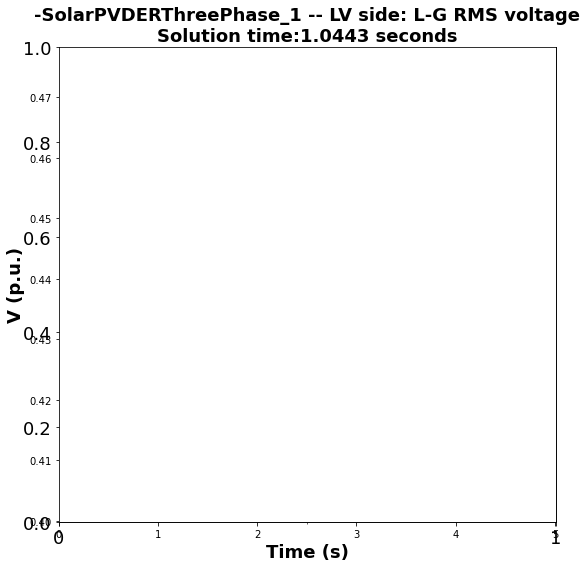

In [10]:
results1.plot_DER_simulation(plot_type='voltage_LV')

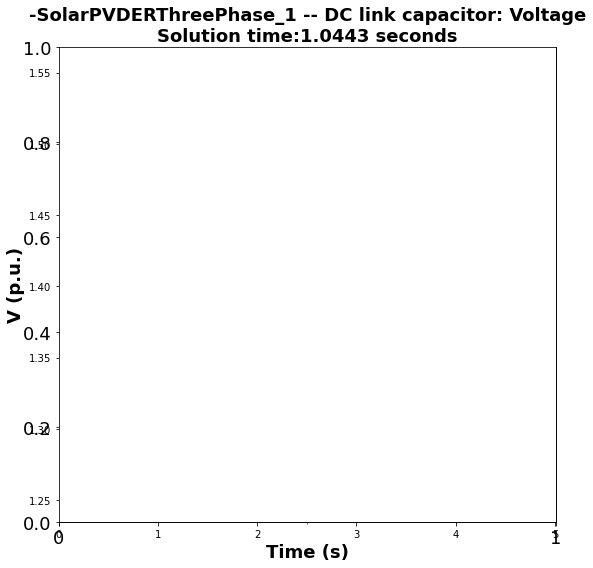

In [11]:
results1.plot_DER_simulation(plot_type='voltage_Vdc')

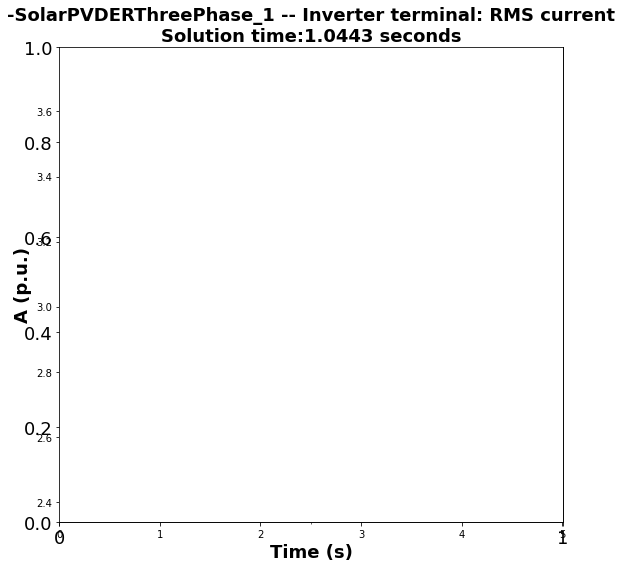

In [12]:
results1.plot_DER_simulation(plot_type='current')

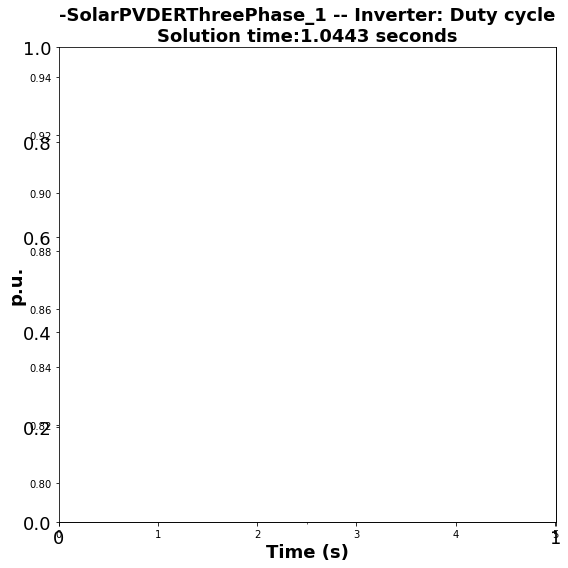

In [13]:
results1.plot_DER_simulation(plot_type='duty_cycle')

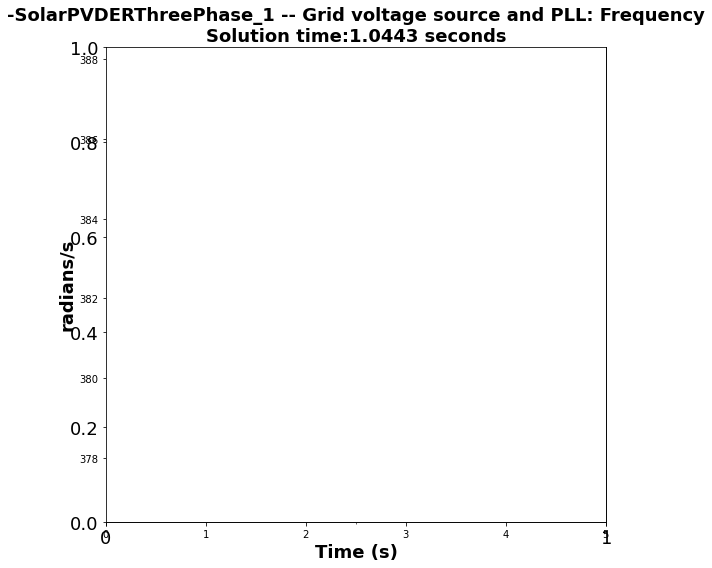

In [14]:
results1.plot_DER_simulation(plot_type='frequency')